In [1]:
from utils import *
from os.path import join
import os

# Load Knowledge Graph
Use the `process_knowledge_graph` function to load knowledge graph data.

In [ ]:
# Load unibiokg
link_root = "database/unibiomap"
data_root = "database/processed"

os.makedirs(data_root, exist_ok=True)
node_map_path = join(data_root, "node_map.json")
graph_path = join(data_root, "unibiomap_simp.dgl")
link_path = join(link_root, "unibiomap.links.tsv")

def nodemap2idmap(node_map):
    return {k: {vv: kk for kk, vv in v.items()} for k, v in node_map.items()}

if os.path.exists(node_map_path) and os.path.exists(graph_path):
    print("Found existing data files, loading...")
    with open(node_map_path, "r") as f:
        node_map = json.load(f)
    graph = dgl.load_graphs(graph_path)[0][0]
else:
    print("Data files not found, processing from raw links...")
    # simplify_edge=True 则忽略细粒度关系，简化关系类型为 头实体类型_尾实体类型，如 compound_protein
    if not os.path.exists(link_path):
        download_raw_kg(link_path)

    graph, node_map = process_knowledge_graph(link_path, simplify_edge=True)
    os.makedirs(data_root, exist_ok=True)
    dgl.save_graphs(graph_path, [graph])
    with open(node_map_path, "w") as f:
        json.dump(node_map, f)

id_map = nodemap2idmap(node_map)
print("Done")


Data files not found, processing from raw links...


Downloading...
From (original): https://drive.google.com/uc?id=1tUe3YVyA2K2Xh_GORWYaOGEKyYE5vnAp
From (redirected): https://drive.google.com/uc?id=1tUe3YVyA2K2Xh_GORWYaOGEKyYE5vnAp&confirm=t&uuid=bbe3536e-7f40-4f27-86f9-9293226f7723
To: /home/fandingxu/Repos/KGdemo/database/unibiomap/unibiomap.links.tsv
100%|██████████| 673M/673M [00:55<00:00, 12.1MB/s] 
fetching data: 12524997 entries [00:11, 1064743.31 entries/s]


Node type counts:
complex: 15869
compound: 1425473
disease: 6795
genetic_disorder: 8436
go: 40401
pathway: 129399
phenotype: 19077
protein: 122079

Edge type counts:
('complex', 'complex-pathway', 'pathway'): 45098
('compound', 'compound-compound', 'compound'): 1161527
('compound', 'compound-disease', 'disease'): 119599
('compound', 'compound-pathway', 'pathway'): 1660675
('compound', 'compound-protein', 'protein'): 2687148
('disease', 'disease-genetic_disorder', 'genetic_disorder'): 7820
('disease', 'disease-pathway', 'pathway'): 289608
('go', 'go-go', 'go'): 79965
('pathway', 'pathway-go', 'go'): 25003
('phenotype', 'phenotype-genetic_disorder', 'genetic_disorder'): 155307
('phenotype', 'phenotype-phenotype', 'phenotype'): 23434
('protein', 'protein-complex', 'complex'): 106670
('protein', 'protein-disease', 'disease'): 116940
('protein', 'protein-genetic_disorder', 'genetic_disorder'): 7321
('protein', 'protein-go', 'go'): 2466657
('protein', 'protein-pathway', 'pathway'): 587097
('

# Get Subgraph
Use the `subgraph_by_node` function to obtain the subgraph for specific nodes.

In [3]:
# Set the query vertex nodes for sampling the subgraph
sample_dict = {
    "protein": ["P05091"],
}
# Set the sample depth
depth = 1
# Set the subgraph save root
sub_save_root = "database/sub/P05091"

In [4]:
# 生成子图
# 使用 subgraph_by_node 函数获取子图
sub_g, new2orig, node_map = subgraph_by_node(graph, sample_dict, node_map, depth=depth)
# 打印子图的基本信息
print(sub_g)
# 获取子图的实体和三元组信息
id_map = nodemap2idmap(node_map)
entities, triplets = report_subgraph(sub_g, id_map, save_root=sub_save_root)

Graph(num_nodes={'complex': 3, 'compound': 370, 'disease': 20, 'genetic_disorder': 1, 'go': 18, 'pathway': 109, 'phenotype': 0, 'protein': 67},
      num_edges={('complex', 'complex-pathway', 'pathway'): 5, ('compound', 'compound-compound', 'compound'): 11, ('compound', 'compound-disease', 'disease'): 10, ('compound', 'compound-pathway', 'pathway'): 655, ('compound', 'compound-protein', 'protein'): 557, ('disease', 'disease-genetic_disorder', 'genetic_disorder'): 0, ('disease', 'disease-pathway', 'pathway'): 288, ('go', 'go-go', 'go'): 4, ('pathway', 'pathway-go', 'go'): 1, ('phenotype', 'phenotype-genetic_disorder', 'genetic_disorder'): 0, ('phenotype', 'phenotype-phenotype', 'phenotype'): 0, ('protein', 'protein-complex', 'complex'): 14, ('protein', 'protein-disease', 'disease'): 53, ('protein', 'protein-genetic_disorder', 'genetic_disorder'): 2, ('protein', 'protein-go', 'go'): 175, ('protein', 'protein-pathway', 'pathway'): 837, ('protein', 'protein-phenotype', 'phenotype'): 0, ('p

# Visualize Subgraph
Using `networkx` and `pyvis` to visualize the subgraph as a static and interactive unit respectively.

In [5]:
# Configs
# 设置每种类型节点的显示数量，-1 表示无限制
display_limits = {
    'complex': 10, 
    'compound': 10,
    'disease': 10,
    'genetic_disorder': 10,
    'go': 10,
    'pathway': 10,
    'phenotype': 10,
    'protein': 10,
}
# 设置必须显示的节点，字典的值为节点名称列表（必须与 id_map 中的名称一致）
must_show = {
    "protein": ["P05091"],
    # 可为其他类型添加必显示节点
}
# 定义不同类型节点的颜色
color_map = {
    'complex': '#FFA07A',
    'compound': '#98FB98',
    'disease': '#FFD700',
    'genetic_disorder': '#FF69B4',
    'go': '#87CEEB',
    'pathway': '#DDA0DD',
    'phenotype': '#808080',
    'protein': '#FF6347'
}
# 设置是否移除自环
remove_self_loop = True

G = convert_subgraph_to_networkx(sub_g, id_map, display_limits, must_show, remove_self_loop)

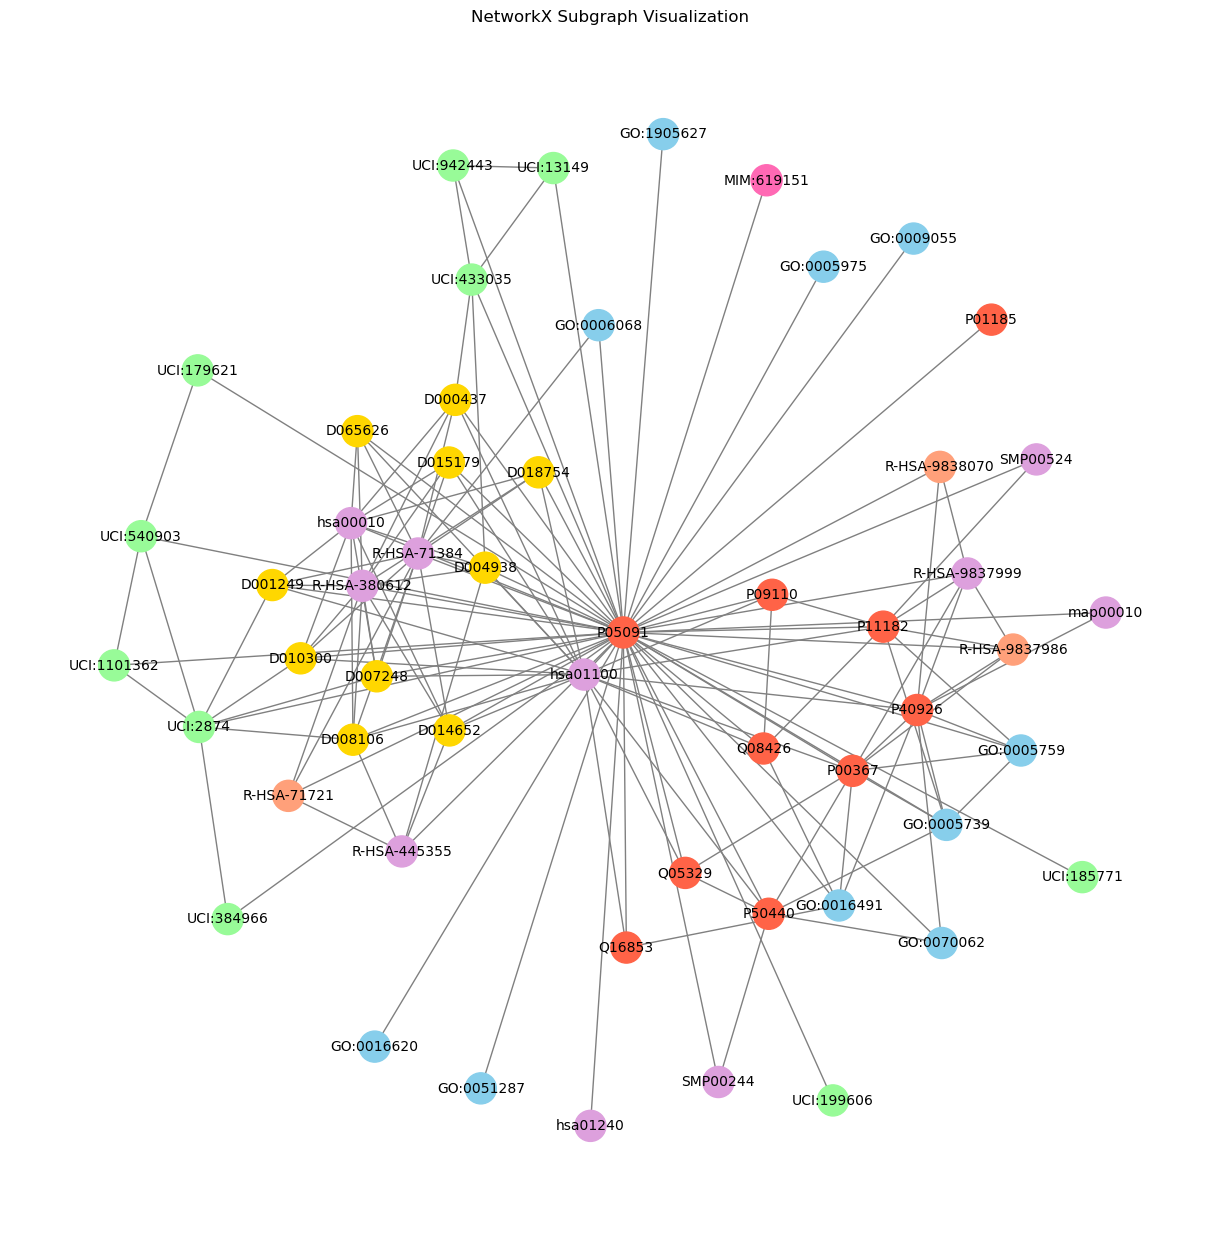

In [6]:
# 导入必要的库
import networkx as nx
# Display the NetworkX graph using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

# 获取节点颜色列表
node_colors = [color_map.get(G.nodes[node]['group'], 'gray') for node in G.nodes]

# 使用节点的 label 作为标签
labels = nx.get_node_attributes(G, 'label')
nx.draw(G, pos, labels=labels, node_size=500, node_color=node_colors, font_size=10, font_color="black", edge_color="gray")
plt.title("NetworkX Subgraph Visualization")
plt.show()

In [7]:
from pyvis.network import Network
from IPython.display import IFrame, display

# 利用 pyvis 进行交互式可视化
# net = Network(height='750px', width='100%', notebook=True, bgcolor='#ffffff', font_color='black')
net = Network(height='750px', width='100%', notebook=True, cdn_resources='in_line', bgcolor='#ffffff', font_color='black')
net.from_nx(G)
# 展示图形（生成的 HTML 文件将自动打开或在 notebook 中显示）
html_root = join(sub_save_root, "dgl_subgraph.html")
net.show(html_root)
display(IFrame(html_root, width="100%", height="750px"))

database/sub/P05091/dgl_subgraph.html
